## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve


from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

import joblib
import matplotlib.pyplot as plt

## 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output = "default")

## 3. Getting Data

In [4]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

In [5]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-05-12,Chennai,Kolkata,11:35:00,14:00:00,145,0.0,No Info,4332
1,Jet Airways,2019-03-01,Banglore,New Delhi,14:05:00,19:10:00,305,1.0,No Info,36235
2,Spicejet,2019-06-03,Kolkata,Banglore,06:55:00,09:30:00,155,0.0,No Info,3873
3,Multiple Carriers,2019-05-18,Delhi,Cochin,08:00:00,21:00:00,780,1.0,No Info,8073
4,Indigo,2019-04-12,Kolkata,Banglore,17:15:00,19:50:00,155,0.0,No Info,4174
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-24,Banglore,Delhi,18:55:00,22:00:00,185,0.0,In-flight meal not included,6144
636,Jet Airways,2019-06-09,Banglore,Delhi,18:55:00,22:00:00,185,0.0,In-flight meal not included,7229
637,Indigo,2019-06-24,Banglore,Delhi,18:55:00,21:50:00,175,0.0,No Info,4823
638,Spicejet,2019-03-21,Mumbai,Hyderabad,13:10:00,14:30:00,80,0.0,No Info,3173


In [6]:
def split_data(df):
    X = df.drop(columns = "price")
    y = df.price.copy()
    return (X, y)

In [7]:
X_train, y_train = split_data(train_df)

print(X_train.shape, y_train.shape)

(640, 9) (640,)


In [8]:
X_val, y_val = split_data(val_df)

print(X_val.shape, y_val.shape)

(160, 9) (160,)


In [9]:
X_test, y_test = split_data(test_df)

print(X_test.shape, y_test.shape)

(200, 9) (200,)


## 3.1 Meta-Info

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


In [11]:
num_cols = ["duration", "total_stops"]

dt_cols = ["date_of_journey","dep_time", "arrival_time"]

cat_cols = [col for col in X_train.columns if (col not in num_cols) and (col not in dt_cols)]

In [12]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

## 4. Data Preprocessing

In [13]:
num_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extracter", DatetimeFeatures(features_to_extract=["month", "day_of_month", "week", "day_of_week"], format = "mixed")),
    ("scaler", StandardScaler())
])

time_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extracter", DatetimeFeatures(features_to_extract=["hour", "minute"], format = "mixed")),
    ("scaler", StandardScaler())
])

In [14]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("time", time_transformer, ["dep_time", "arrival_time"])
])

In [15]:
preprocessor.fit_transform(X_train)

array([[-0.91272074, -1.14869596,  0.        , ...,  0.55991623,
         0.0258655 , -1.42966815],
       [-0.59746927,  0.3364867 ,  0.        , ..., -1.07140269,
         0.76487984, -0.85056206],
       [-0.89301752, -1.14869596,  0.        , ...,  1.64746218,
        -0.71314883,  0.30765011],
       ...,
       [-0.85361109, -1.14869596,  0.        , ...,  1.64746218,
         1.06048557,  1.46586228],
       [-1.04079165, -1.14869596,  0.        , ..., -0.7995162 ,
         0.0258655 ,  0.30765011],
       [ 1.99350377,  1.82166935,  0.        , ...,  0.55991623,
        -0.26974023,  0.59720315]])

## 5. Model Selection

In [16]:
algorithms = {
    "linear regression" : LinearRegression(),
    "SVM" : SVR(),
    "random forest" : RandomForestRegressor(n_estimators=10),
    "xgboost" : XGBRegressor(n_estimators=10)
}

In [17]:
data = pd.concat([train_df, val_df], axis=0)
#data

X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [18]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker = "o",
        label=label
    )
    
    ax.fill_between(
        x=sizes,
        y1=mean_scores - std_scores,
        y2=mean_scores + std_scores,
        alpha=0.5
    )

In [19]:
def plot_learning_curves(name, algorithms, figsize = (12,4)):
    model = Pipeline(steps = [
        ("preprocessing", preprocessor),
        ("algorithm", algorithms)
    ])
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42
        
    )
    
    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    
    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"
    
    fig, ax = plt.subplots(figsize=figsize)
    
    #Training Curve
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )
    
    #Test Curve
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )
    
    ax.set(xlabel="Training Set Size", ylabel="R2-score", title=name)
    
    ax.legend(loc = "lower right")
    
    plt.show()

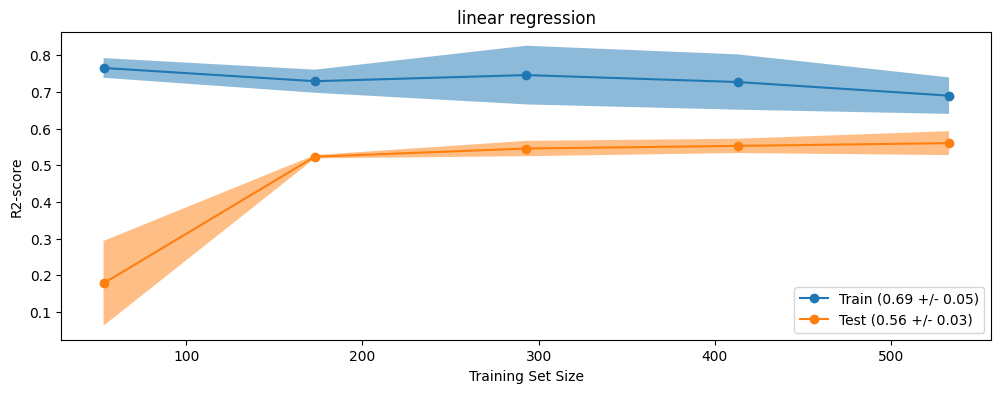

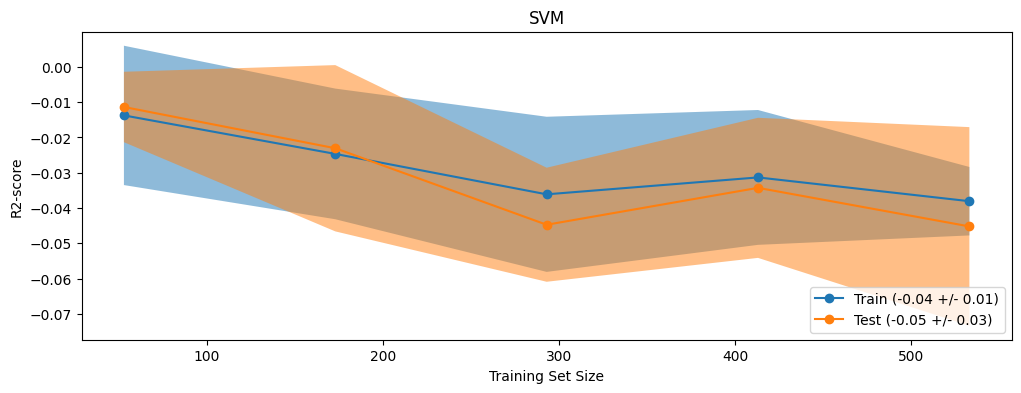

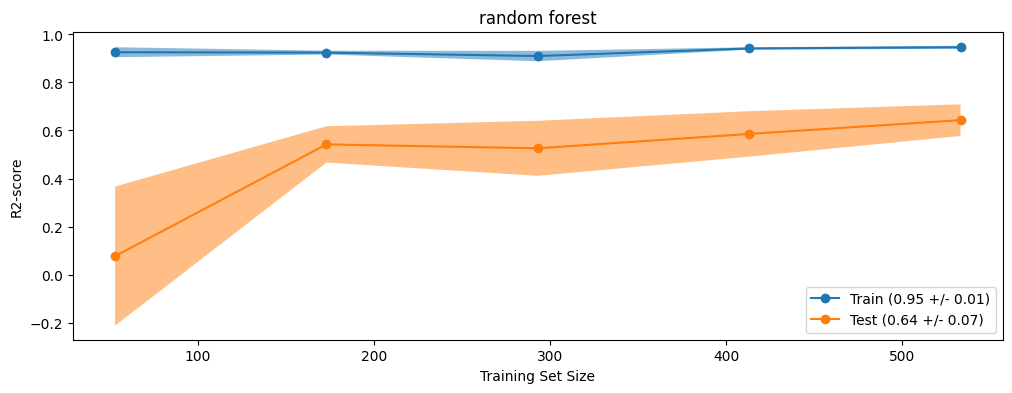

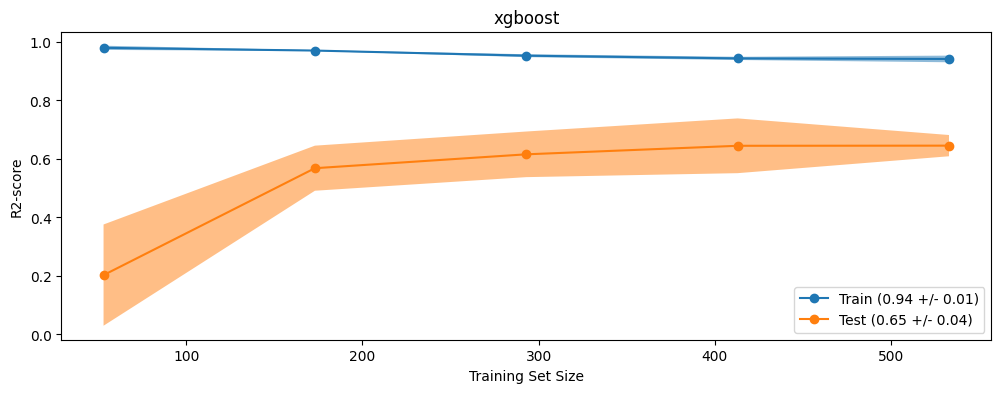

In [20]:
for name, alg in algorithms.items():
    plot_learning_curves(name, alg)

## 6. Model Training

In [21]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("alg", RandomForestRegressor(n_estimators=10))
])

In [22]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_week'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extracter',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('alg', RandomForestRegressor(n_estimators=10))])

In [23]:
def evaluate_model(X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [24]:
print(f"R2-Score on Training Data is {evaluate_model(X_data, y_data)}")

R2-Score on Training Data is 0.9222143113412612


In [25]:
print(f"R2-Score on Test Data is {evaluate_model(X_test, y_test)}")

R2-Score on Test Data is 0.8794532106889247


## 7. Model Persistence(Saving the model)

In [26]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [27]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_week'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extracter',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('alg', RandomForestRegressor(n_estimators=10))])

In [28]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.8794532106889247